In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import math
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display, detect_musical_regions
from util import fft_frequencies, find_nearest
import mappings
import pickle
import PIL
import IPython.display

/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
model = pickle.load(open('renyi_shannon_prollharm_model.sav', 'rb'))

/Library/Python/3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianNB from version 0.19.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [42]:
n_fft=2048
kernel=[800,800]
y, sr = librosa.load('../data/example.wav', sr=44100)
spec = np.abs(librosa.stft(y, n_fft=n_fft))
time_span = [0,len(y)/sr]

In [43]:
spec_512 = np.abs(librosa.stft(y,n_fft=512, hop_length=512, center=False, window='boxcar'))
spec_4096 = np.abs(librosa.stft(y,n_fft=4096, hop_length=4096, center=False, window='boxcar'))

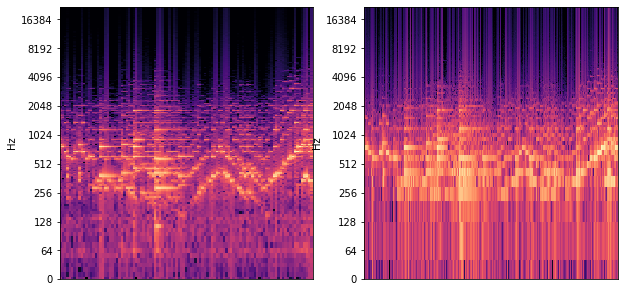

In [44]:
plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec_4096, ref=np.max), y_axis='log', sr=44100)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(spec_512, ref=np.max), y_axis='log', sr=44100)

In [10]:
def energy_reference(y, time_range, freq_range, sr=44100):
    y_slice = y[math.floor(time_range[0] * sr): math.floor(time_range[1] * sr)]
    spec = np.fft.rfft(y_slice)
    freqs = np.fft.rfftfreq(len(y_slice), 1./sr)
    idx_start = find_nearest(freqs, freq_range[0])
    idx_stop = find_nearest(freqs, freq_range[1])
    return np.sum(np.abs(spec[idx_start:idx_stop])**2) / len(y_slice)  # duvida no espectro simetrico aqui!!! é só fazer *2 mesmo?? 

In [50]:
energy_reference(y,[0,len(y)*sr], [0,22050])

208.478063610143

In [52]:
np.sum(spec_4096**2) * 2 / 4096

205.20840454101562

In [53]:
np.sum(spec_512**2) * 2 / 512

208.68638610839844

Testando no nosso algoritmo de multi-resolucao

In [2]:
from classes import SingleResSpectrogram, MultiResSpectrogram

In [3]:
y, sr = librosa.load('../data/example.wav', sr=44100)
n_fft = 2048
hop_size = n_fft
spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size, window='boxcar'))

# Every SingleResSpectrogram has a spectrogram matrix and two arrays: x_axis and y_axis
x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, [0,len(y)/sr], spec.shape)
base_spec = SingleResSpectrogram(spec, x_axis, y_axis)

In [4]:
# Every MultiResSpectrogram starts with a base single resolution spectrogram
multires_spec = MultiResSpectrogram(base_spec)

#### Part 3.2 Detecting interesting subregions with the "detect_musical_regions" script

In [5]:
# First, load Naive-Bayes model trained using 800x800 kernel and piano roll + harmonics reference value
model = pickle.load(open('renyi_shannon_prollharm_model.sav', 'rb'))

# Detect musical subregions using 800x800 kernel and a probability threshold of 80%

kernel = [800,800]
threshold = 0.8
indices, shape_feature_map = detect_musical_regions.detect_musical_regions(model, spec, mode='threshold', pct_or_threshold=threshold)

/Library/Python/3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianNB from version 0.19.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
# Convert detected indices to freq. ranges and time ranges
interesting_regions = detect_musical_regions.musical_regions_to_ranges(indices, shape_feature_map, x_axis, y_axis, kernel)

In [7]:
# Detected regions are given by [freq_range, time_range] 
interesting_regions[:5]

[([258.3984375, 430.6640625], [6.4186046511627906, 9.627906976744185]),
 ([258.3984375, 430.6640625], [0.0, 3.2093023255813953]),
 ([689.0625, 1098.193359375], [0.0, 3.2093023255813953]),
 ([258.3984375, 430.6640625], [3.2093023255813953, 6.4186046511627906]),
 ([430.6640625, 689.0625], [3.2093023255813953, 6.4186046511627906])]

#### Part 3.3: Refining detected regions using "stft_zoom"

In [11]:
def normalize_subregion(spec_zoom, new_window_size, time_range, freq_range, y):
    energy_ref = energy_reference(y, time_range, freq_range)
    energy_old = np.sum(spec_zoom ** 2)
    return math.sqrt(energy_ref / energy_old) * spec_zoom

In [12]:
for subregion in interesting_regions:
    freq_range = subregion[0]
    time_range = subregion[1]
    
    # Zoom in using "stft_zoom" (it prints out what subband processing method was applied)
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=3)
    
    spec_zoom = normalize_subregion(spec_zoom, window_size, time_range, freq_range, y)
    
    # Each refined subregion is a SingleResSpectrogram of its own...
    refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis)
    # ...that is inserted into a MultiResSpectrogram
    multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)

ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
undersampling
[1644.18945312 2977.78320312]
(3150, 0) [172.216796875, 1505.810546875]
undersampling
[1644.18945312 2977.78320312]
(3150, 0) [172.216796875, 1505.810546875]
ring mod + lpf
undersampling
[1644.18945312 2977.78320312]
(3150, 0) [172.216796875, 1505.810546875]


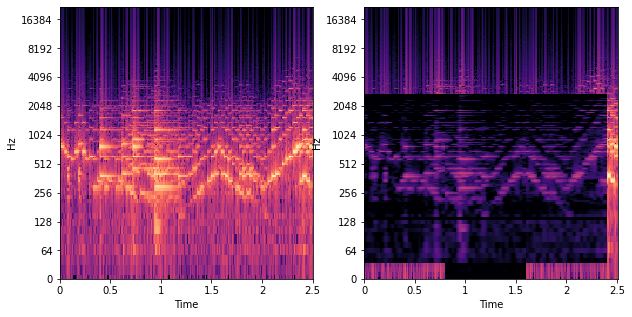

In [13]:
# Then, we can generate a visualization
vis = multires_spec.generate_visualization()

# ...and compare it to the original single resolution spectrogram
plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(vis, ref=np.max), y_axis='log', x_axis='time', sr=sr)